In [11]:
%load_ext rpy2.ipython
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
import numpy as np

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
n_int_AB = 5
n_int_ABC = 7
ILS = 30

In [13]:
t_A = 200000
t_B = 200000
t_C = 200000
t_1 = max([t_A, t_B, t_C])
t_2 = 80000
N_AB = -t_2/np.log(3/2*ILS/100)
N_ABC = 60000
t_3 = t_1*5
r = 0.5e-8
mu = 2e-8
n_int_AB = 5
n_int_ABC = 7

t_out = t_1+t_2+t_3+2*N_ABC

N_ref = N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, coal_ABC)[-2]*N_ref
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_AB, coal_AB)*N_ref
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, coal_ABC)*N_ref
cut_ABC_new = t_1+t_2+cutpoints_ABC(n_int_ABC, 3)*N_ref

In [29]:
%%R

library(tidyverse)
theme_set(theme_bw())

hid_tab <- read_csv('../data/hid_tab.csv', show_col_types = FALSE)
tree_tab <- read_csv('../data/tree_tab.csv', show_col_types = FALSE)
post_tab <- read_csv('../data/post_tab.csv', show_col_types = FALSE)
tree_tab_cut <- read_csv('../data/tree_tab_cutpoints.csv', show_col_types = FALSE)
post_tab_cut <- read_csv('../data/post_tab_cutpoints.csv', show_col_types = FALSE)

In [30]:
%%R

tree_tab_cut_2 <- tree_tab_cut %>%
    mutate(
        start = end,
        end = start+1,
        topology_end = lead(topology),
        int_1_end = lead(int_1),
        int_2_end = lead(int_2)
    )
    
tree_tab_2 <- tree_tab %>%
    mutate(
        start = end,
        end = start+1,
        topology_end = lead(topology),
        int_1_end = lead(int_1),
        int_2_end = lead(int_2)
    )

In [27]:
%%R -i cut_ABC_new -i cut_AB -i cut_ABC

ggplot() +
    geom_rect(aes(xmin = 1, xmax = 2, ymin = start, ymax = end, fill = 'Second coalescent'),
              color = 'black',
              data = tibble(start = cut_ABC, end = lead(cut_ABC))) +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = start, ymax = end, fill = 'First coalescent'),
              color = 'black',
              data = tibble(start = cut_ABC_new, end = lead(cut_ABC_new))) +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = start, ymax = end, fill = 'First coalescent'),
              color = 'black',
              data = tibble(start = cut_AB, end = lead(cut_AB))) +
    # geom_rect(aes(xmin = 0, xmax = 2, ymin = start, ymax = end, fill = 'Isolation'),
    #           color = 'black',
    #           data = tibble(start = 0, end = min(cut_AB)))  +
    geom_hline(aes(yintercept = y), 
               color = 'red', linetype = 2,
               data = tibble(y = c(min(cut_AB), max(cut_AB)))) +
    theme_void() +
    theme(legend.position = 'none')
    
ggsave('../plots/times_and_cutpoints.pdf', width = 3.5, height = 9)

In [33]:
%%R -w 2000 -h 700 -r 150 -i n_int_AB -i n_int_ABC 


p1 <- post_tab_cut %>%
    mutate(is_V0 = topology == 0) %>%
    group_by(pos, is_V0, int_1) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)) +
    geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
    geom_segment(aes(x = start, xend = end, 
                     y = int_1+(!(topology == 0))*(n_int_AB), yend = int_1+(!(topology == 0))*(n_int_AB)), 
                 color = 'green3', size = 2,
                 data = tree_tab_cut) +
    # geom_segment(aes(x = start, xend = end, 
    #                  y = int_1+(!(topology == 0))*(n_int_AB), yend = int_1_end+(!(topology_end == 0))*(n_int_AB)), 
    #              color = 'green3', size = 1, lineend = 'round',
    #              data = tree_tab_cut_2) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno"
                         ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))), 
        # labels = c(0:(n_int_AB-1), 0:(n_int_ABC-1)),
        labels = paste0('F', c(0:(n_int_AB+n_int_ABC-1))),
        expand = c(0, 0),
        sec.axis = dup_axis(
            # breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC)))-0.5,
            # labels = sprintf("%.0f", round(c(cut_AB[0:(length(cut_AB)-1)], cut_ABC_new)))
            # labels = rep('', length(round(c(cut_AB[0:(length(cut_AB)-1)], cut_ABC_new))))
        )
    ) +
    theme(
        axis.title.y.right = element_blank()
    ) +
    labs(y = 'First coalescent', x = 'Position')

`summarise()` has grouped output by 'pos', 'is_V0'. You can override using the `.groups` argument.


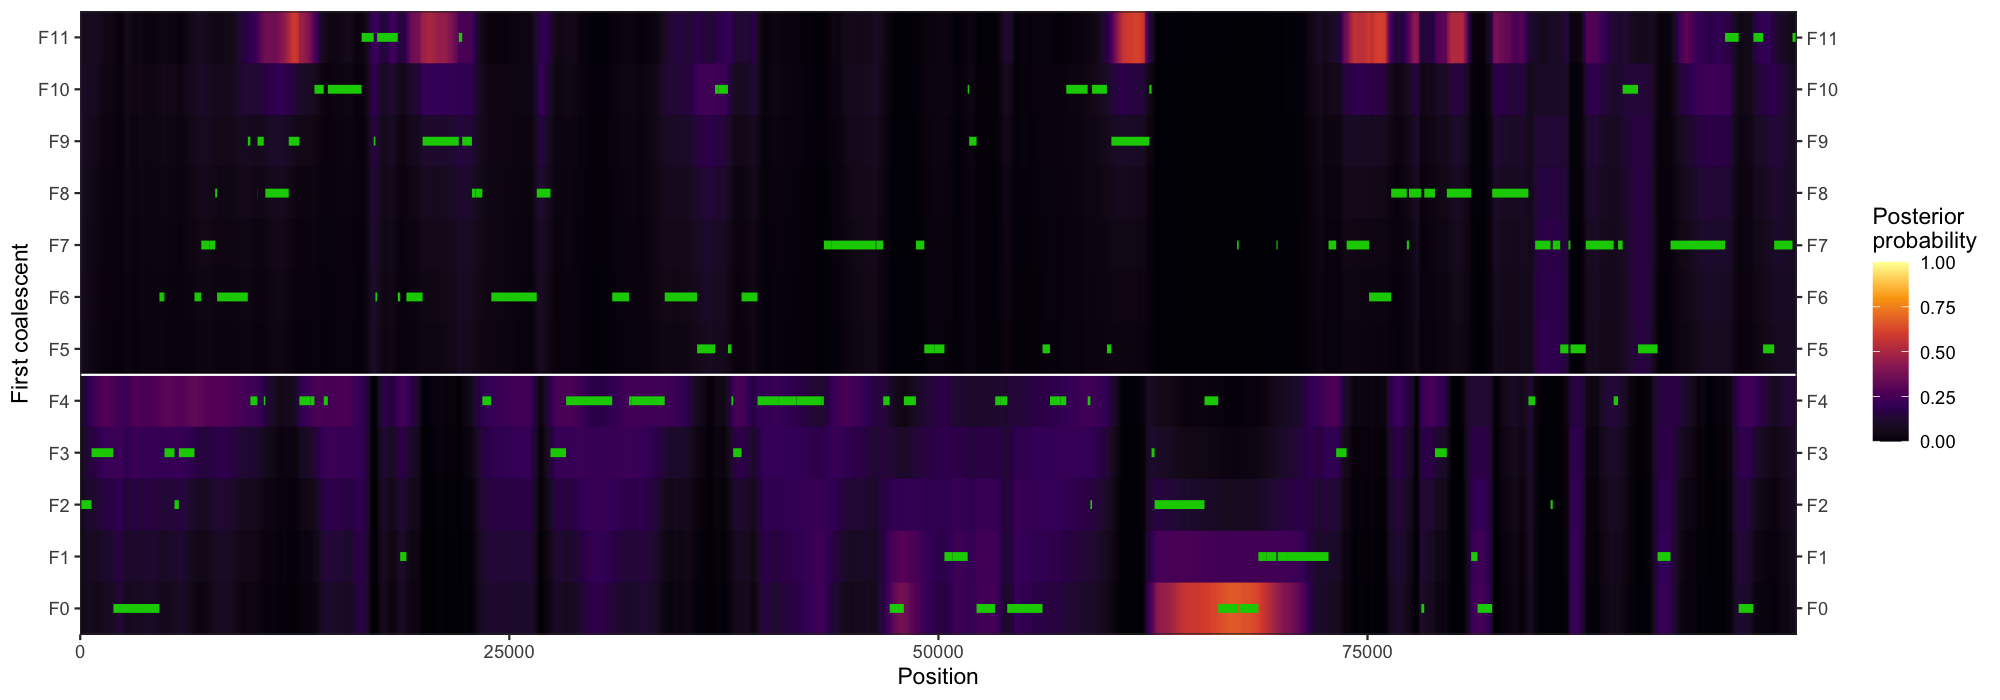

In [34]:
%%R -w 2000 -h 700 -r 150

p1

In [19]:
%%R -w 2000 -h 700 -r 150 -i cut_ABC

p2 <- post_tab %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_2, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2), 
                 color = 'green3', size = 2, 
                 data = tree_tab) +
    # geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2_end), 
    #              color = 'green3', size = 1, lineend = 'round', linetype = 2,
    #              data = tree_tab_2) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = 0:(n_int_ABC-1), 
        # labels = 0:(n_int_ABC-1),
        labels = paste0('S', 0:(n_int_ABC-1)),
        expand = c(0, 0),
        sec.axis = dup_axis(
            # breaks = (0:n_int_ABC)-0.5,
            # labels = sprintf("%.0f", round(cut_ABC))
            # breaks = seq(-0.5, n_int_ABC-0.5, 0.5),
            # labels = c(rbind(rep('', length(cut_ABC)-1), paste0('S', 0:(n_int_ABC-1))), '')
        )
    ) +
    labs(y = 'Second coalescent') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank()
    )

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


In [20]:
%%R -w 2000 -h 700 -r 150

p3 <- post_tab %>%
    group_by(pos, topology) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, topology, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = topology, yend = topology), 
                 color = 'green3', size = 2,
                 data = tree_tab) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         limits = c(0, 1),
                         option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0, 1, 2, 3), 
        labels = c('V0', 'V1', 'V2', 'V3'),
        expand = c(0, 0),
        sec.axis = dup_axis()
    ) +
    labs(y = 'Topology') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank()
    )

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


In [35]:
%%R -w 2000 -h 1000 -r 150 -i ILS

library(patchwork)

plt_tot <- (p3/p2/p1 + 
  plot_layout(heights = c(4, n_int_ABC, n_int_AB+n_int_ABC), guides = 'collect')) & theme(legend.position = 'none')

ggsave(paste0('../plots/posterior_decoding_', n_int_AB, '_', n_int_ABC, '_', round(ILS), '_combined.tiff'), plt_tot, 
       width = 14, height = 9)